In [1]:

import numpy as np
import scipy as sc
from scipy import fftpack
from numpy.linalg import inv
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D

In [2]:
I = complex(0.,1.)
print (np.arange(10))

[0 1 2 3 4 5 6 7 8 9]


John Boyd's Grids. I'm starting here because I remember learning about these in graduate school. One of the key points is that the symmetries are such that you solve on the half plane only, therefore the grids go from 0 to $\pi$. John defines the grids in the following way:

Fourier Sine Series:
\begin{equation} x_i = \frac{i}{N} \qquad \qquad i = 1, N-1 \qquad \text{N-1 degrees of freedom}\end{equation}
And in this case the Sine series is defined as:
\begin{equation} g(x_i) = \sum_{n=1}^{N-1} \hat{g}_n \text{sin}(n\pi x_i)\end{equation}

Fourier Cosine Series:
\begin{equation} x_j = \frac{j}{N} \qquad \qquad j = 0, N \qquad \text{N+1 degrees of freedom -- includes the endpoints}\end{equation}
And in this case the Cosine series is defined as:
\begin{equation} f(x_j) = \sum_{m=0}^{M} \hat{f}_m \text{cos}(m\pi x_j)\end{equation}

The main point again is that the two grids are different sizes, therefore you have to take this into account when using them to compute derivatives of each other. For example I anticipate the cosine grid is 2 bigger than the sine grid meaning I'll have to pass a smaller array to the sine transforms in the derivatives.







In [3]:
NB = 32
FNB = np.float_(NB)
delta_cosine = 1./FNB
delta_sine = 1./FNB
print (delta_sine)
# The following array should start at 0 and end at NB and have NB+1 degrees of freedom. This is the
# endpoint grid because cosines do have values at the end points.
xb_cosine = np.arange(0.,FNB+1.)
xb_cosine_int = np.arange(0.,FNB+1.)
print (xb_cosine)
xb_cosine[0] = 0.
for k in np.arange(1,NB+1):
    xb_cosine[k] = xb_cosine[k-1] + delta_cosine
print (xb_cosine)
# The following array should start at 1 and end at NB-2 and have NB-1 degrees of freedom. This is
# because the sin(0) and sin(pi) are both zero.
xb_sine = np.arange(0.,FNB-1.)
xb_sine_int = np.arange(0.,FNB-1.)
# Since I'm using this _int for plotting and I want the Sine gridpoints to coincide with the Cosine gridpoints
# I have to shift things here.
for k in np.arange(0,NB-1):
    xb_sine_int[k] = k+1
print (xb_sine_int)
xb_sine[0] = delta_sine
for k in np.arange(1,NB-1):
    xb_sine[k] = xb_sine[k-1] + delta_sine
print (xb_sine)
##
# The main point of all this is that John points out that the sine grid is naturally interior
# and the cosine grid is naturally exterior.
#
Lz = np.pi
zg_cosine = np.linspace(0, Lz, NB+1, endpoint = True)
zg_sine = zg_cosine[1:NB-1]
print(zg_sine)
print(zg_cosine)

0.03125
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.]
[ 0.       0.03125  0.0625   0.09375  0.125    0.15625  0.1875   0.21875
  0.25     0.28125  0.3125   0.34375  0.375    0.40625  0.4375   0.46875
  0.5      0.53125  0.5625   0.59375  0.625    0.65625  0.6875   0.71875
  0.75     0.78125  0.8125   0.84375  0.875    0.90625  0.9375   0.96875
  1.     ]
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.]
[ 0.03125  0.0625   0.09375  0.125    0.15625  0.1875   0.21875  0.25
  0.28125  0.3125   0.34375  0.375    0.40625  0.4375   0.46875  0.5
  0.53125  0.5625   0.59375  0.625    0.65625  0.6875   0.71875  0.75
  0.78125  0.8125   0.84375  0.875    0.90625  0.9375   0.96875]
[ 0.09817477  0.19634954  0.29452431  0.39269908  0.49087385  0.58904862
  0.68722339  

SciPy's Grids

In [4]:
NS = 32
FNS = np.float_(NS)
#
# For the same N they have different grid spacings
#
delta_s_cosine = 1./(FNS+1.)
delta_s_sine = 1./(FNS-1.)
# The cosine grid
xs_cosine = np.arange(0.,FNS)
xs_cosine_int = np.arange(0.,FNS)
for k in np.arange(0,NS):
    xs_cosine[k] = (np.float_(k))/(FNS-1.)
print (xs_cosine)
# The sine grid
xs_sine = np.arange(0.,FNS)
xs_sine_int = np.arange(0.,FNS)
for k in np.arange(0,NS):
    xs_sine[k] = (np.float_(k)+1.)/(FNS+1.)
print (xs_sine)
#
# These two grids are the same size but clearly at different points. To use them together
# you'll need to do some finagling with the sizes or definitions. What if I make the cosine grid 2 bigger?
#
# The cosine grid part II
NS_II = NS+2
FNS_II = np.float_(NS_II)
xs_cosine_II = np.arange(0.,FNS_II)
xs_cosine_int_II = np.arange(0.,FNS_II)
for k in np.arange(0,NS_II):
    xs_cosine_II[k] = (np.float_(k))/(FNS_II-1.)
print (xs_cosine_II)
#
# The above works fine -- the Cosine grid has to be 2 bigger than the other
# so that the end points are included.
#

[ 0.          0.03225806  0.06451613  0.09677419  0.12903226  0.16129032
  0.19354839  0.22580645  0.25806452  0.29032258  0.32258065  0.35483871
  0.38709677  0.41935484  0.4516129   0.48387097  0.51612903  0.5483871
  0.58064516  0.61290323  0.64516129  0.67741935  0.70967742  0.74193548
  0.77419355  0.80645161  0.83870968  0.87096774  0.90322581  0.93548387
  0.96774194  1.        ]
[ 0.03030303  0.06060606  0.09090909  0.12121212  0.15151515  0.18181818
  0.21212121  0.24242424  0.27272727  0.3030303   0.33333333  0.36363636
  0.39393939  0.42424242  0.45454545  0.48484848  0.51515152  0.54545455
  0.57575758  0.60606061  0.63636364  0.66666667  0.6969697   0.72727273
  0.75757576  0.78787879  0.81818182  0.84848485  0.87878788  0.90909091
  0.93939394  0.96969697]
[ 0.          0.03030303  0.06060606  0.09090909  0.12121212  0.15151515
  0.18181818  0.21212121  0.24242424  0.27272727  0.3030303   0.33333333
  0.36363636  0.39393939  0.42424242  0.45454545  0.48484848  0.51515152


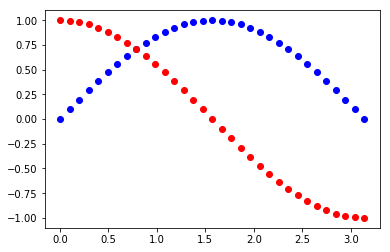

In [5]:
plt.figure()
plt.plot(zg_cosine,np.sin(zg_cosine),'bo')
plt.plot(zg_cosine,np.cos(zg_cosine),'ro')
plt.show()

Set up the Scipy grids

In [6]:
# Lenth to use to test scalings
L = np.float_(4.)
Nx_cosine = 32
Nx_sine = Nx_cosine - 2
# This array for the cosine grid will have elements 0 to 31
FNx_cosine = np.float_(Nx_cosine)
# This array for the sine grid will have elements 0 to 29
FNx_sine = np.float_(Nx_sine)

# Define the cosine grid
x_grid_cosine = np.arange((FNx_cosine))
x_grid_sine = np.arange((FNx_sine))
for k in np.arange(0,Nx_cosine):
        x_grid_cosine[k] = (np.float_(k))/(FNx_cosine-1.)*L
print (x_grid_cosine)
        
# Define the sine grid
for k in np.arange(0,Nx_sine):
    x_grid_sine[k] = (np.float_(k)+1.)/(FNx_sine+1.)*L
print (x_grid_sine)

#
# Don't forget the complex Fourier grid goes from 0 to 2 pi
# This is still 0 to 1 but twice as many points because morally speaking we're going to 2 pi
#


[ 0.          0.12903226  0.25806452  0.38709677  0.51612903  0.64516129
  0.77419355  0.90322581  1.03225806  1.16129032  1.29032258  1.41935484
  1.5483871   1.67741935  1.80645161  1.93548387  2.06451613  2.19354839
  2.32258065  2.4516129   2.58064516  2.70967742  2.83870968  2.96774194
  3.09677419  3.22580645  3.35483871  3.48387097  3.61290323  3.74193548
  3.87096774  4.        ]
[ 0.12903226  0.25806452  0.38709677  0.51612903  0.64516129  0.77419355
  0.90322581  1.03225806  1.16129032  1.29032258  1.41935484  1.5483871
  1.67741935  1.80645161  1.93548387  2.06451613  2.19354839  2.32258065
  2.4516129   2.58064516  2.70967742  2.83870968  2.96774194  3.09677419
  3.22580645  3.35483871  3.48387097  3.61290323  3.74193548  3.87096774]


Do the cosine and sine transforms by hand and compare to the SciPy transform to make sure I understand the conventions.

\begin{equation} f(x) = \sum_{n=0}^{Nc-1} \hat{f}_n \text{cos}(n \pi x) \qquad \text{for all} \quad x \in (0,1)\end{equation}. 

To find the transformed variables multiply by the basis functions and integrate over the domain,

For all $n^\prime \in (0,Nc-1)$
\begin{equation}
\int_0^1 ~f(x)~\text{cos}(n^\prime \pi x) ~dx= \sum_{n=0}^{Nc-1} \hat{f}_n \int_0^1 ~\text{cos}(n \pi x)\text{cos}(n^\prime \pi x) ~dx
\end{equation}

In the normal coarse of events the right hand side is orthogal over the half Fourier interval in the following way:
\begin{equation}
\int_0^1 \text{cos}(n \pi x)\text{cos}(n^\prime \pi x) = \begin{cases} 
0 & :   n \ne n^\prime \\  1 & : n = n^\prime = 0 \\ 1/2 & : n = n^\prime \ne 0\end{cases}
\end{equation}

But numerically we'll use the trapezoidal rule,
\begin{eqnarray}
\int_0^1 ~\text{cos}(n \pi x)\text{cos}(n^\prime \pi x) & = & \frac{1}{Nc-1} \frac{1}{2} \left( ~\text{cos}(n \pi x[0])\text{cos}(n^\prime \pi x[0]) + ~\text{cos}(n \pi x[Nc-1])\text{cos}(n^\prime \pi x[Nc-1]) \right) \\
&& + \frac{1}{Nc-1}  \sum_{p=1}^{Nc-2} ~\text{cos}(n \pi x[p])\text{cos}(n^\prime \pi x[p])
\end{eqnarray}
And
\begin{eqnarray}
\int_0^1 ~f(x)~\text{cos}(n^\prime \pi x) ~dx & = & \frac{1}{Nc-1} \frac{1}{2} \left(f(x[0])\text{cos}(n^\prime \pi x[0]) + f(x[Nc-1])\text{cos}(n^\prime \pi x[Nc-2]) \right) \\
&& + \frac{1}{Nc-1}  \sum_{p=1}^{Nc-2}  f(x[p])~\text{cos}(n^\prime \pi x[p])
\end{eqnarray}
For the half domain $\text{cos}(0) = 1.$ and $\text{cos}(n \pi) = (-1)^n$ so the end points can be reduced to,
\begin{eqnarray}
\int_0^1 ~\text{cos}(n \pi x)\text{cos}(n^\prime \pi x) & = & \frac{1}{Nc-1} \frac{1}{2} \left( 1 + (-1)^n~(-1)^{n^\prime} \right) \\
&& + \frac{1}{Nc-1}  \sum_{p=1}^{Nc-2} ~\text{cos}(n \pi x[p])\text{cos}(n^\prime \pi x[p])
\end{eqnarray}
And
\begin{eqnarray}
\int_0^1 ~f(x)~\text{cos}(n^\prime \pi x) ~dx & = & \frac{1}{Nc-1} \frac{1}{2} \left(f(x[0]) + f(x[Nc-1]) (-1)^{n^\prime} \right) \\
&& + \frac{1}{Nc-1}  \sum_{p=1}^{Nc-2}  f(x[p])~\text{cos}(n^\prime \pi x[p])
\end{eqnarray}

The formula for the transform should be,
For $n^\prime  ~\in  ~(0,Nc-1)$
\begin{eqnarray}
\hat{f}_{n^\prime} = & \frac{1}{Nc-1}  \left(f(x[0]) + f(x[Nc-1]) (-1)^{n^\prime} \right)  + 2 \frac{1}{Nc-1} ~\sum_{p=1}^{Nc-2}  f(x[p])~\text{cos}(n^\prime \pi x[p])
\end{eqnarray}
Contrast this to SciPy's formula for the cosine transform,
For $k ~\in ~(0,N-1)$
\begin{equation}
y[k] = x_0 + (-1)^k~x_{N-1} + 2 \sum_{n=1}^{N-2}~x_n ~\text{cos}\left(\frac{\pi n k}{N-1}\right)
\end{equation}

Which is the same formula so we should be good on the cosine transform

In [7]:
# Check the trapezoidal rule with cosine orthogonality
#
# Integrate the rhs
#
cosine_orth = np.zeros((Nx_cosine,Nx_cosine))
for n_prime in range(Nx_cosine):
    for n in range(Nx_cosine):
        cosine_orth[n,n_prime] = 0.
#       This loop goes to Nx_cosine-1
        for p in range(Nx_cosine):
            if p == 0:
                cosine_orth[n,n_prime] += np.cos(np.float_(n)*np.pi*x_grid_cosine[p])*np.cos(np.float_(n_prime)*np.pi*x_grid_cosine[p])
            elif p == Nx_cosine-1:
                cosine_orth[n,n_prime] += np.cos(np.float_(n)*np.pi*x_grid_cosine[p])*np.cos(np.float_(n_prime)*np.pi*x_grid_cosine[p])
            else:
                cosine_orth[n,n_prime] += 2. * np.cos(np.float_(n)*np.pi*x_grid_cosine[p])*np.cos(np.float_(n_prime)*np.pi*x_grid_cosine[p])
        cosine_orth[n,n_prime] *= 1./2./np.float_(Nx_cosine-1.)
#
# Integrate the test function
#
function_hats = np.zeros((Nx_cosine))
for n_prime in range(Nx_cosine):
    function_hats[n_prime] = 0.
#   This loop goes to Nx_cosine-1
    for p in range(Nx_cosine):
        if p == 0:
            function_hats[n_prime] += np.cos(np.pi*x_grid_cosine[p])*np.cos(np.float_(n_prime)*np.pi*x_grid_cosine[p])
        elif p == Nx_cosine-1:
            function_hats[n_prime] += np.cos(np.pi*x_grid_cosine[p])*np.cos(np.float_(n_prime)*np.pi*x_grid_cosine[p])
        else:
            function_hats[n_prime] += 2. * np.cos(np.pi*x_grid_cosine[p])*np.cos(np.float_(n_prime)*np.pi*x_grid_cosine[p])
    function_hats[n_prime] *= 1./2./np.float_(Nx_cosine-1.)
#
# Then normalize the function hats by the cosine_ortho
#
for n_prime in range(Nx_cosine):
    function_hats[n_prime] /= cosine_orth[n_prime,n_prime]

print (function_hats)
#
# Now try it with SciPy's Cosine Transform
#
function_hats_scipy = np.random.random_sample((Nx_cosine))
function_scipy = np.random.random_sample((Nx_cosine))
print (type(function_hats_scipy),np.size(function_hats_scipy))
print (type(function_scipy),np.size(function_scipy))
for p in range(Nx_cosine):
    function_scipy[p] = np.cos(np.pi*x_grid_cosine[p])
print ('a',function_scipy)
    
function_hats_scipy = fftpack.dct(function_scipy,type=1)
# Normalize by a factor of 1/(Nx_cosine-1) in this direction
function_hats_scipy *= 1./(Nx_cosine-1.)
print (function_hats_scipy)
#
# Which works perfectly.
#

[  1.79068230e-17   1.00000000e+00  -4.29763751e-17  -3.58136460e-17
  -4.29763751e-17   2.68602345e-16  -2.00556417e-16  -1.30361671e-15
   2.25625970e-16  -1.21766396e-16  -6.73296544e-16   7.95062940e-16
   6.51808356e-16  -2.22044605e-16   1.82649594e-15  -3.28052997e-15
   1.48268494e-15   1.31077944e-15  -2.96536989e-15  -1.24631488e-15
  -1.14603667e-16   1.81933321e-15   2.12733057e-15  -1.77635684e-15
   1.23915215e-15  -5.73018335e-17  -4.36926481e-15  -5.08553773e-15
   4.29763751e-16  -1.28212853e-15   1.00000000e+00   1.79068230e-17]
<class 'numpy.ndarray'> 32
<class 'numpy.ndarray'> 32
a [ 1.          0.91895781  0.68896692  0.34730525 -0.05064917 -0.44039415
 -0.75875812 -0.95413926 -0.99486932 -0.87434662 -0.61210598 -0.25065253
  0.15142778  0.52896401  0.82076344  0.97952994  0.97952994  0.82076344
  0.52896401  0.15142778 -0.25065253 -0.61210598 -0.87434662 -0.99486932
 -0.95413926 -0.75875812 -0.44039415 -0.05064917  0.34730525  0.68896692
  0.91895781  1.        ]


Now go back again.

In [8]:
#
# Sum by hand
#
function_test_return = np.random.random_sample((Nx_cosine))
for p in range(Nx_cosine):
    function_test_return[p] = 0.
    for n in range(Nx_cosine):
        function_test_return[p] += function_hats[n]*np.cos(np.pi*np.float_(n)*x_grid_cosine[p])
print (function_test_return)
print (function_scipy)
#
# Inverse transform by scipy Normalize by a factor of 2 in this direction
#
function_return_scipy = fftpack.idct(function_hats_scipy,type=1)
function_return_scipy *= 1./2.
print (function_return_scipy)

[ 2.          1.83791562  1.37793384  0.69461051 -0.10129834 -0.8807883
 -1.51751625 -1.90827851 -1.98973865 -1.74869323 -1.22421197 -0.50130506
  0.30285556  1.05792802  1.64152688  1.95905988  1.95905988  1.64152688
  1.05792802  0.30285556 -0.50130506 -1.22421197 -1.74869323 -1.98973865
 -1.90827851 -1.51751625 -0.8807883  -0.10129834  0.69461051  1.37793384
  1.83791562  2.        ]
[ 1.          0.91895781  0.68896692  0.34730525 -0.05064917 -0.44039415
 -0.75875812 -0.95413926 -0.99486932 -0.87434662 -0.61210598 -0.25065253
  0.15142778  0.52896401  0.82076344  0.97952994  0.97952994  0.82076344
  0.52896401  0.15142778 -0.25065253 -0.61210598 -0.87434662 -0.99486932
 -0.95413926 -0.75875812 -0.44039415 -0.05064917  0.34730525  0.68896692
  0.91895781  1.        ]
[ 1.          0.91895781  0.68896692  0.34730525 -0.05064917 -0.44039415
 -0.75875812 -0.95413926 -0.99486932 -0.87434662 -0.61210598 -0.25065253
  0.15142778  0.52896401  0.82076344  0.97952994  0.97952994  0.82076344


Now do the fraking sine transform. The main difference is that there is an interior grid.

\begin{equation}x_j = \frac{j+1}{Ns+1} \quad \text{for all} ~j \in (0,Ns-1) \end{equation}

And we also shift the summation so that it omits the first and last.

\begin{equation}
g(x) = \sum_{n=0}^{Ns-1} \hat{g}_n ~\text{sin}\left[(n+1) \pi ~x_j \right] \quad \text{for all} ~~~n ~\in ~(0,Ns-1)
\end{equation}

Orthogonality for the Sine series over 0,1

\begin{equation}
\int_0^1 \text{sin}((n+1) \pi x) ~\text{sin}((n^\prime+1) \pi x) = \begin{cases} 
0 & :   n \ne n^\prime  \\ 1/2 & : n = n^\prime \ne 0\end{cases}
\end{equation}

But numerically we'll use the trapezoidal rule,
\begin{eqnarray}
\int_0^1 ~\text{sin}((n+1) \pi x)~\text{sin}((n^\prime+1) \pi x) & = & 
  \frac{1}{Ns-1}  \sum_{p=0}^{Ns-1} ~\text{sin}((n+1) ~\pi ~x[p])~\text{sin}((n^\prime+1) ~\pi ~x[p])
\end{eqnarray}
And
\begin{eqnarray}
\int_0^1 ~f(x)~\text{sin}((n^\prime+1) ~\pi ~x) ~dx & = &  \frac{1}{Ns-1}  \sum_{p=0}^{Ns-1}  f(x[p])~\text{sin}((n^\prime+1) \pi x[p])
\end{eqnarray}
We expect the formula for the transform to follow:

For a $n^\prime = 0,Ns-1$

\begin{equation}
\hat{g}_{n^\prime} = 2. \sum_{p=0}^{Ns-1} g(x[p]) ~\text{sin}\left[(n^\prime+1)~\pi ~x[p] \right]
\end{equation}

Compare this to scipy's formula

\begin{equation}
y[k] = 2 \sum_{n=0}^{N-1} x[n] sin \left( \frac{\pi (n+1) (k+1)}{N-1}\right) \quad \text{for all} k~~~ \in (0,N-1)
\end{equation}

Which should be the same.


In [9]:
# Check the trapezoidal rule with cosine orthogonality
#
# Integrate the rhs
#
sine_orth = np.zeros((Nx_sine,Nx_sine))
for n_prime in range(Nx_sine):
    for n in range(Nx_sine):
        sine_orth[n,n_prime] = 0.
#       This loop goes to Nx_sine-1
        for p in range(Nx_sine):
            sine_orth[n,n_prime] += np.sin((np.float_(n)+1.)*np.pi*x_grid_sine[p])*np.sin((np.float_(n_prime)+1.)*np.pi*x_grid_sine[p])
        sine_orth[n,n_prime] *= 1./np.float_(Nx_sine+1)
#
# Notice that the actual interval is Nc, not Ns, so we have to modify the scaling factor to be the right number
# for the trap rule which is Nx_sine + 1
#
#        if n == n_prime:
#            print n+1, n_prime+1, sine_orth[n,n_prime]
#
# Integrate the test function which is just sine pi x
#
function_sine_hats = np.zeros((Nx_sine))
for n_prime in range(Nx_sine):
    function_sine_hats[n_prime] = 0.
#  This loop goes to Nx_cosine-1
    for p in range(Nx_sine):
            function_sine_hats[n_prime] += np.sin(np.pi*x_grid_sine[p])*np.sin(np.float_((n_prime)+1.)*np.pi*x_grid_sine[p])
    function_sine_hats[n_prime] *= 1./np.float_(Nx_sine+1.)
#
# Then normalize the function hats by the sine_ortho
#
for n_prime in range(Nx_sine):
    function_sine_hats[n_prime] /= sine_orth[n_prime,n_prime]
print (function_sine_hats)

#
# Now try it with SciPy's Sine Transform
#
function_sine_hats_scipy = np.random.random_sample((Nx_sine))
function_sine_scipy = np.random.random_sample((Nx_sine))
for p in range(Nx_sine):
    function_sine_scipy[p] = np.sin(np.pi*x_grid_sine[p])
print ('a',function_sine_scipy)
    
function_sine_hats_scipy = fftpack.dst(function_sine_scipy,type=1)
# Normalize by a factor of 1/(Nx_cosine-1) in this direction
function_sine_hats_scipy *= 1./(Nx_sine+1.)
print (function_sine_hats_scipy)
#
# Which works perfectly.
#

[  1.00000000e+00   0.00000000e+00  -2.50695522e-16  -2.14881876e-17
   3.79624647e-16  -7.41342471e-16   5.14821161e-16  -2.10852841e-16
   1.64742771e-16   1.07440938e-17  -1.41822038e-15  -1.79426366e-15
   1.50775449e-15  -2.31535221e-15   5.80091530e-15   2.19089979e-15
   1.51491722e-15  -1.90170460e-15  -1.51491722e-15  -8.20132492e-16
   5.33623325e-16  -9.40108206e-16  -1.30540740e-15   8.06702375e-16
  -6.91203367e-16   1.00636345e-15  -6.18501666e-15  -2.79704575e-15
  -2.96895125e-15  -1.00000000e+00]
a [ 0.39435586  0.72479279  0.93775213  0.99871651  0.89780454  0.65137248
  0.29936312 -0.10116832 -0.48530196 -0.79077574 -0.96807712 -0.98846832
 -0.84864426 -0.57126822 -0.20129852  0.20129852  0.57126822  0.84864426
  0.98846832  0.96807712  0.79077574  0.48530196  0.10116832 -0.29936312
 -0.65137248 -0.89780454 -0.99871651 -0.93775213 -0.72479279 -0.39435586]
[ -2.14881876e-17  -2.16224887e-16   1.43746179e-16   1.00000000e+00
  -1.47223622e-16   4.75426150e-16  -4.30024

Now sum it all up.

In [10]:
#
# Sum by hand
#
function_sine_return = np.random.random_sample((Nx_sine))
for p in range(Nx_sine):
    function_sine_return[p] = 0.
    for n in range(Nx_sine):
        function_sine_return[p] += function_sine_hats[n]*np.sin(np.pi*(np.float_(n)+1.)*x_grid_sine[p])
print (function_sine_return)
print (function_sine_scipy)
#
# Inverse transform by scipy Normalize by a factor of 2 in this direction
#
function_sine_return_scipy = fftpack.idst(function_sine_hats_scipy,type=1)
function_sine_return_scipy *= 1./2.
print (function_sine_return_scipy)
#
# Need to write this all up.
#

[ 0.78871171  1.44958557  1.87550426  1.99743301  1.79560908  1.30274497
  0.59872625 -0.20233664 -0.97060393 -1.58155147 -1.93615424 -1.97693665
 -1.69728851 -1.14253643 -0.40259704  0.40259704  1.14253643  1.69728851
  1.97693665  1.93615424  1.58155147  0.97060393  0.20233664 -0.59872625
 -1.30274497 -1.79560908 -1.99743301 -1.87550426 -1.44958557 -0.78871171]
[ 0.39435586  0.72479279  0.93775213  0.99871651  0.89780454  0.65137248
  0.29936312 -0.10116832 -0.48530196 -0.79077574 -0.96807712 -0.98846832
 -0.84864426 -0.57126822 -0.20129852  0.20129852  0.57126822  0.84864426
  0.98846832  0.96807712  0.79077574  0.48530196  0.10116832 -0.29936312
 -0.65137248 -0.89780454 -0.99871651 -0.93775213 -0.72479279 -0.39435586]
[ 0.39435586  0.72479279  0.93775213  0.99871651  0.89780454  0.65137248
  0.29936312 -0.10116832 -0.48530196 -0.79077574 -0.96807712 -0.98846832
 -0.84864426 -0.57126822 -0.20129852  0.20129852  0.57126822  0.84864426
  0.98846832  0.96807712  0.79077574  0.48530196 

Try to do the same as above with the transform only with a shifted grid

In [11]:
function_sine_2_hats_scipy = np.random.random_sample((Nx_cosine))
function_sine_2_scipy = np.random.random_sample((Nx_cosine))
function_sine_2_return_scipy = np.random.random_sample((Nx_cosine))
function_sine_2_scipy[0] = 0.
function_sine_2_scipy[Nx_cosine-1] = 0.
for p in range(1,Nx_cosine-1):
    function_sine_2_scipy[p] = np.sin(np.pi*x_grid_cosine[p])
print ('a',function_sine_2_scipy)

function_sine_2_hats_scipy[0] = 0.
function_sine_2_hats_scipy[Nx_cosine-1] = 0.
# Remember to assign the right array values to the sine transform!
function_sine_2_hats_scipy[1:Nx_cosine-1:1] = fftpack.dst(function_sine_2_scipy[1:Nx_cosine-1:1],type=1)
# Normalize by a factor of 1/(Nx_cosine-1) in this direction
function_sine_2_hats_scipy *= 1./(Nx_sine+1.)
print (function_sine_2_hats_scipy)


a [ 0.          0.39435586  0.72479279  0.93775213  0.99871651  0.89780454
  0.65137248  0.29936312 -0.10116832 -0.48530196 -0.79077574 -0.96807712
 -0.98846832 -0.84864426 -0.57126822 -0.20129852  0.20129852  0.57126822
  0.84864426  0.98846832  0.96807712  0.79077574  0.48530196  0.10116832
 -0.29936312 -0.65137248 -0.89780454 -0.99871651 -0.93775213 -0.72479279
 -0.39435586  0.        ]
[  0.00000000e+00  -2.14881876e-17  -2.16224887e-16   1.43746179e-16
   1.00000000e+00  -1.47223622e-16   4.75426150e-16  -4.30024068e-17
  -3.58136460e-18  -1.75159168e-16   2.54276886e-16  -3.46180143e-17
  -1.46835948e-16   7.70754953e-17  -2.86509168e-17  -2.35772874e-17
  -5.73018335e-17  -1.30160650e-16   2.36370063e-16  -7.63540735e-17
  -6.08831981e-17   1.14533238e-16   1.43254584e-17  -5.87632874e-17
   1.07440938e-17   1.54270861e-16  -3.58136460e-17  -3.89047149e-17
   1.11022302e-16  -1.21015003e-16   1.07440938e-17   0.00000000e+00]


Now take the inverse transform and see how that goes.

In [12]:
#
# Inverse transform by scipy Normalize by a factor of 2 in this direction
#
function_sine_2_return_scipy[1:Nx_cosine-1:1] = fftpack.idst(function_sine_2_hats_scipy[1:Nx_cosine-1:1],type=1)
function_sine_2_return_scipy *= 1./2.
function_sine_2_return_scipy[0] = 0.
function_sine_2_return_scipy[Nx_cosine-1] = 0.
print (function_sine_2_return_scipy)
#
# Works great!
#

[ 0.          0.39435586  0.72479279  0.93775213  0.99871651  0.89780454
  0.65137248  0.29936312 -0.10116832 -0.48530196 -0.79077574 -0.96807712
 -0.98846832 -0.84864426 -0.57126822 -0.20129852  0.20129852  0.57126822
  0.84864426  0.98846832  0.96807712  0.79077574  0.48530196  0.10116832
 -0.29936312 -0.65137248 -0.89780454 -0.99871651 -0.93775213 -0.72479279
 -0.39435586  0.        ]


Finally ready to take a derivative.

In [13]:
function_cosine_derivative = np.random.random_sample((Nx_cosine))
function_hats_cosine_derivative = np.random.random_sample((Nx_cosine))
for n in range(Nx_cosine):
    function_hats_cosine_derivative[n] = -np.float_(n)*function_hats_scipy[n]
#
# Then invert
#
function_cosine_derivative[1:Nx_cosine-1:1] = fftpack.idst(function_hats_cosine_derivative[1:Nx_cosine-1:1],type=1)
function_cosine_derivative[1:Nx_cosine-1:1] *= 1./2.
function_cosine_derivative[0] = 0.
function_cosine_derivative[Nx_cosine-1] = 0.

print (function_cosine_derivative)
#
# The right answer is -sin(pi x) which this is
#

[ 0.         -1.57742342 -2.89917115 -3.75100853 -3.99486603 -3.59121816
 -2.60548993 -1.19745249  0.40467329  1.94120785  3.16310295  3.87230848
  3.9538733   3.39457703  2.28507286  0.80519408 -0.80519408 -2.28507286
 -3.39457703 -3.9538733  -3.87230848 -3.16310295 -1.94120785 -0.40467329
  1.19745249  2.60548993  3.59121816  3.99486603  3.75100853  2.89917115
  1.57742342  0.        ]


In [14]:
def set_sym_initial(x_grid,Nx,f,L):
    # On the half plan it is the sine that is symmetric
    for k1 in range(0,Nx):
        f[k1] = np.sin(np.pi*x_grid[k1]/L)
    return 
def set_sym_d(x_grid,Nx,f,L):
    for k1 in range(0,Nx):
        f[k1] = np.pi/L*np.cos(np.pi*x_grid[k1]/L)
    return 
def set_sym_dd(x_grid,Nx,f,L):
    for k1 in range(0,Nx):
        f[k1] = -(np.pi/L)**2*np.sin(np.pi*x_grid[k1]/L)
    return 
def set_asym_tanh(x_grid,Nx,f,L):
    # Tanh, like cosine, is asymmetric
    for k1 in range(0,Nx):
        f[k1] = np.tanh(2.*np.pi/L*x_grid[k1]-np.pi)
    return 
def set_asym_tanh_d(x_grid,Nx,f,L):
    # Tanh, like cosine, is asymmetric
    for k1 in range(0,Nx):
        f[k1] = 2*np.pi/L*(1.-np.tanh(2.*np.pi/L*x_grid[k1]-np.pi)**2)
    return 
def set_asym_initial(x_grid,Nx,f,L):
    for k1 in range(0,Nx):
        f[k1] = np.cos(np.pi*x_grid[k1]/L)
    return 
def set_asym_d(x_grid,Nx,f,L):
    for k1 in range(0,Nx):
        f[k1] = -np.pi/L*np.sin(np.pi*x_grid[k1]/L)
    return 
def set_asym_dd(x_grid,Nx,f,L):
    for k1 in range(0,Nx):
        f[k1] = - (np.pi/L)**2*np.cos(np.pi*x_grid[k1]/L)
    return #


Test transforms and derivatives of Fourier Sine, Cosine, and Exponential series and FFTS.

In [15]:
#
# Initialize function arrays
#
fsym = np.arange((np.float_(Nx_cosine)))
fsym_trans = np.arange((np.float_(Nx_cosine)))
fsymd_exact = np.arange((np.float_(Nx_cosine)))
fsymdd_exact = np.arange((np.float_(Nx_cosine)))
fsymd = np.arange((np.float_(Nx_cosine)))
fsymdd = np.arange((np.float_(Nx_cosine)))

fasym = np.arange((np.float_(Nx_cosine)))
fasymtanh = np.arange((np.float_(Nx_cosine)))
fasymtanh_d = np.arange((np.float_(Nx_cosine)))
fasymtanh_d_exact = np.arange((np.float_(Nx_cosine)))
fasym_trans = np.arange((np.float_(Nx_cosine)))
fasymd_exact = np.arange((np.float_(Nx_cosine)))
fasymdd_exact = np.arange((np.float_(Nx_cosine)))
fasymd = np.arange((np.float_(Nx_cosine)))
fasymdd = np.arange((np.float_(Nx_cosine)))

#
# Initialize spectral arrays
#
fsym_spec = np.arange((np.float_(Nx_cosine)))
fsymd_spec = np.arange((np.float_(Nx_cosine)))
fsymd_spec_fullgrid = np.arange((np.float_(Nx_cosine)))
fsymdd_spec = np.arange((np.float_(Nx_cosine)))

fasym_spec = np.arange((np.float_(Nx_cosine)))
fasymtanh_spec = np.arange((np.float_(Nx_cosine)))
fasymtanh_d_spec = np.arange((np.float_(Nx_cosine)))
fasymd_spec = np.arange((np.float_(Nx_cosine)))
fasymdd_spec = np.arange((np.float_(Nx_cosine)))
#
# Set the initial functions
#
set_sym_initial(x_grid_cosine,Nx_cosine,fsym,L)
set_sym_d(x_grid_cosine,Nx_cosine,fsymd_exact,L)
set_sym_dd(x_grid_cosine,Nx_cosine,fsymdd_exact,L)

set_asym_initial(x_grid_cosine,Nx_cosine,fasym,L)
set_asym_d(x_grid_cosine,Nx_cosine,fasymd_exact,L)
set_asym_dd(x_grid_cosine,Nx_cosine,fasymdd_exact,L)
set_asym_tanh(x_grid_cosine,Nx_cosine,fasymtanh,L)
set_asym_tanh_d(x_grid_cosine,Nx_cosine,fasymtanh_d_exact,L)



Have a look

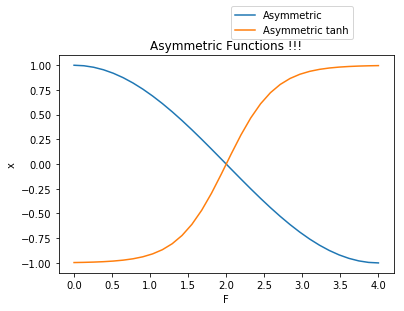

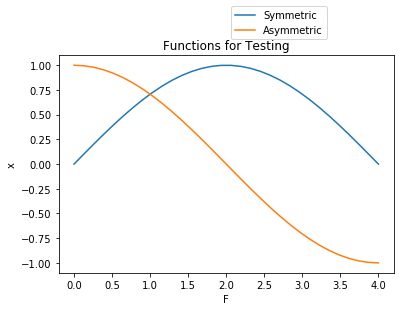

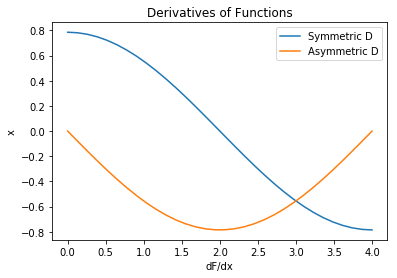

In [16]:
#
# Functions
#
fig_tanh = plt.figure()
fig,ax = plt.subplots()
p1, = plt.plot(x_grid_cosine,fasym)
p2, = plt.plot(x_grid_cosine,fasymtanh)
plt.legend([p1, p2], ["Asymmetric", "Asymmetric tanh"],bbox_to_anchor=(.5, 1.05))
#plt.ylim(0,1.)
#plt.xlim(-1.1,1.1)
plt.title('Asymmetric Functions !!!')
plt.xlabel('F')
plt.ylabel('x')
plt.show()
#
fig_originfunctions = plt.figure()
fig,ax = plt.subplots()
p1, = plt.plot(x_grid_cosine,fsym)
p2, = plt.plot(x_grid_cosine,fasym)
plt.legend([p1, p2], ["Symmetric", "Asymmetric"],bbox_to_anchor=(.5, 1.05))
#plt.ylim(0,1.)
#plt.xlim(-1.1,1.1)
plt.title('Functions for Testing')
plt.xlabel('F')
plt.ylabel('x')
plt.show()
#
# Derivatives of Functions
#
fig_originfunctions_derivatives = plt.figure()
fig,ax = plt.subplots()
p4, = plt.plot(x_grid_cosine,fsymd_exact)
p5, = plt.plot(x_grid_cosine,fasymd_exact)
plt.legend([p4, p5], ["Symmetric D", "Asymmetric D"])
#plt.ylim(0,1.)
#plt.xlim(-1.1,1.1)
plt.title('Derivatives of Functions')
plt.xlabel('dF/dx')
plt.ylabel('x')
plt.show()


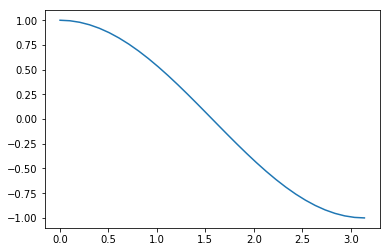

In [17]:
plt.plot(x_grid_cosine*np.pi/L,np.cos(x_grid_cosine/L*np.pi))
plt.show()

Take Fourier Transforms of functions then go back to double check the conventions.

asym [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.]
2.08166817117e-15
3.21964677141e-15


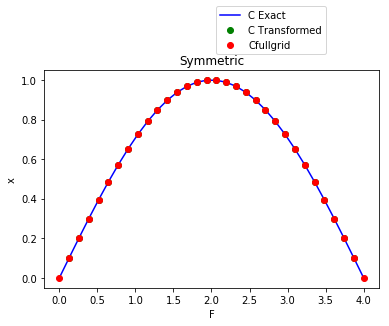

fasym [ 1.          0.99486932  0.97952994  0.95413926  0.91895781  0.87434662
  0.82076344  0.75875812  0.68896692  0.61210598  0.52896401  0.44039415
  0.34730525  0.25065253  0.15142778  0.05064917 -0.05064917 -0.15142778
 -0.25065253 -0.34730525 -0.44039415 -0.52896401 -0.61210598 -0.68896692
 -0.75875812 -0.82076344 -0.87434662 -0.91895781 -0.95413926 -0.97952994
 -0.99486932 -1.        ]
fasym_trans [ 1.          0.99486932  0.97952994  0.95413926  0.91895781  0.87434662
  0.82076344  0.75875812  0.68896692  0.61210598  0.52896401  0.44039415
  0.34730525  0.25065253  0.15142778  0.05064917 -0.05064917 -0.15142778
 -0.25065253 -0.34730525 -0.44039415 -0.52896401 -0.61210598 -0.68896692
 -0.75875812 -0.82076344 -0.87434662 -0.91895781 -0.95413926 -0.97952994
 -0.99486932 -1.        ]


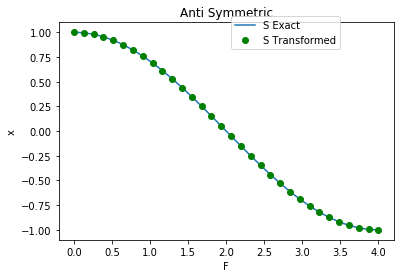

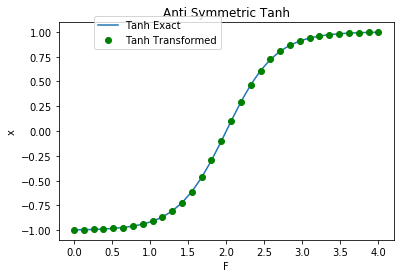

In [18]:
#
# Recall that on the interval 0 to pi, it is the cosine that is antisymmetric
#

fasym_spec = fftpack.dct(fasym,type=1)/(np.float_(Nx_cosine)-1.)
print ('asym',fsym_spec)
fasym_trans = fftpack.idct(fasym_spec,type=1)*.5

fasym_tanh_spec = fftpack.dct(fasymtanh,type=1)/(np.float_(Nx_cosine)-1.)
fasym_tanh_trans = fftpack.idct(fasym_tanh_spec,type=1)*.5

#
# This is with the grid that doesn't contain the end points.
#

fsym_spec[1:Nx_cosine-1] = fftpack.dst(fsym[1:Nx_cosine-1:1],type=1)/(np.float_(Nx_sine)+1.)
fsym_trans[1:Nx_cosine-1] = fftpack.idst(fasym_spec[1:Nx_cosine-1],type=1)*.5

#
# Try it with the full grid -- which should work because the end points are just zero, then there's no
# faffing with array sizes.
#
fsym_spec_fullgrid = fftpack.dst(fsym,type=1)/(np.float_(Nx_cosine)+1.)
fsym_fullgrid_trans = fftpack.idst(fsym_spec_fullgrid,type=1)*.5

print (max(fsym-fsym_trans))
print (max(fasym-fasym_trans))

fig_cosinetransforms = plt.figure()
fig,ax = plt.subplots()
pct1, = plt.plot(x_grid_cosine,fsym,'b-')
pct2, = plt.plot(x_grid_cosine[1:Nx_cosine-1],fsym_trans[1:Nx_cosine-1], 'go')
pct3, = plt.plot(x_grid_cosine,fsym_fullgrid_trans, 'ro')
plt.legend([pct1, pct2, pct3], ["C Exact", "C Transformed", "Cfullgrid"],bbox_to_anchor=(.5, 1.05))
#plt.ylim(0,1.)
#plt.xlim(-1.1,1.1)
plt.title('Symmetric')
plt.xlabel('F')
plt.ylabel('x')
plt.show()

print ('fasym',fasym)
print ('fasym_trans',fasym_trans)

fig_sinetransforms = plt.figure()
fig,ax = plt.subplots()
pst1, = plt.plot(x_grid_cosine,fasym)
pst2, = plt.plot(x_grid_cosine,fasym_trans, 'go')
plt.legend([pst1, pst2], ["S Exact", "S Transformed"],bbox_to_anchor=(.5, 1.05))
#plt.ylim(0,1.)
#plt.xlim(-1.1,1.1)
plt.title('Anti Symmetric')
plt.xlabel('F')
plt.ylabel('x')
plt.show()

fig_checktanhvisually = plt.figure()
fig,ax = plt.subplots()
pst1, = plt.plot(x_grid_cosine,fasymtanh)
pst2, = plt.plot(x_grid_cosine,fasym_tanh_trans, 'go')
plt.legend([pst1, pst2], ["Tanh Exact", "Tanh Transformed"],bbox_to_anchor=(.5, 1.05))
#plt.ylim(0,1.)
#plt.xlim(-1.1,1.1)
plt.title('Anti Symmetric Tanh')
plt.xlabel('F')
plt.ylabel('x')
plt.show()


Try taking even derivatives

In [19]:
#
# Even derivatives
#
for kx in range(Nx_cosine):
    fasymdd_spec[kx] = -(np.float_(kx) * np.pi / L)**2 * fasym_spec[kx] 

for kx in range(1,Nx_cosine-1):
    fsymdd_spec[kx] = -(np.float_(kx) * np.pi / L)**2 * fsym_spec[kx] 

fasymdd = np.zeros(Nx_cosine)
fsymdd = np.zeros(Nx_cosine)
    
fasymdd = fftpack.idct(fasymdd_spec,type=1)*.5
fsymdd[1:Nx_cosine-1] = fftpack.idst(fsymdd_spec[1:Nx_cosine-1],type=1)*.5


Plot them up

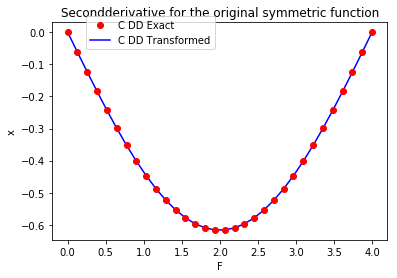

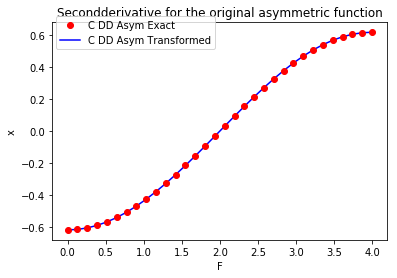

In [20]:
fig_cosinetransforms = plt.figure()
fig,ax = plt.subplots()
pct1, = plt.plot(x_grid_cosine,fsymdd, 'b-')
pct2, = plt.plot(x_grid_cosine,fsymdd_exact, 'ro')
plt.legend([pct2, pct1], ["C DD Exact", "C DD Transformed"],bbox_to_anchor=(.5, 1.05))
#plt.ylim(0,1.)
#plt.xlim(-1.1,1.1)
plt.title('Secondderivative for the original symmetric function')
plt.xlabel('F')
plt.ylabel('x')
plt.show()
fig_cosinetransforms = plt.figure()
fig,ax = plt.subplots()
pct1, = plt.plot(x_grid_cosine,fasymdd, 'b-')
pct2, = plt.plot(x_grid_cosine,fasymdd_exact, 'ro')
plt.legend([pct2, pct1], ["C DD Asym Exact", "C DD Asym Transformed"],bbox_to_anchor=(.5, 1.05))
#plt.ylim(0,1.)
#plt.xlim(-1.1,1.1)
plt.title('Secondderivative for the original asymmetric function')
plt.xlabel('F')
plt.ylabel('x')
plt.show()


Taking Odd derivatives

In [21]:
#
# Odd derivatives
#
for kx in range(Nx_cosine):
    fasymd_spec[kx] = -np.float_(kx) * np.pi / L * fasym_spec[kx] 

fsymd_spec = np.zeros(Nx_cosine)
    
for kx in range(1,Nx_cosine-1):
    fsymd_spec[kx] = np.float_(kx) * np.pi / L * fsym_spec[kx] 

fasymd = np.zeros(Nx_cosine)
fsymd = np.zeros(Nx_cosine)
    
fasymd[1:Nx_cosine-1] = fftpack.idst(fasymd_spec[1:Nx_cosine-1],type=1)*.5
fsymd = fftpack.idct(fsymd_spec,type=1)*.5


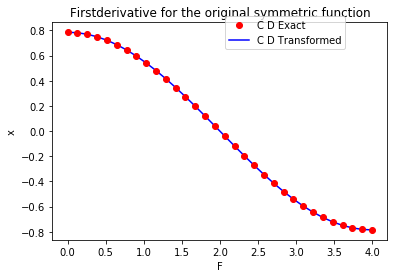

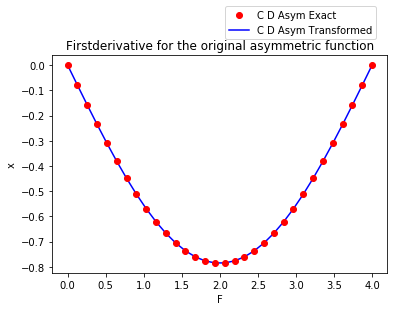

In [22]:
fig_cosinetransforms = plt.figure()
fig,ax = plt.subplots()
pct1, = plt.plot(x_grid_cosine,fsymd, 'b-')
pct2, = plt.plot(x_grid_cosine,fsymd_exact, 'ro')
plt.legend([pct2, pct1], ["C D Exact", "C D Transformed"],bbox_to_anchor=(.5, 1.05))
#plt.ylim(0,1.)
#plt.xlim(-1.1,1.1)
plt.title('Firstderivative for the original symmetric function')
plt.xlabel('F')
plt.ylabel('x')
plt.show()
fig_cosinetransforms = plt.figure()
fig,ax = plt.subplots()
pct1, = plt.plot(x_grid_cosine,fasymd, 'b-')
pct2, = plt.plot(x_grid_cosine,fasymd_exact, 'ro')
plt.legend([pct2, pct1], ["C D Asym Exact", "C D Asym Transformed"],bbox_to_anchor=(.5, 1.05))
#plt.ylim(0,1.)
#plt.xlim(-1.1,1.1)
plt.title('Firstderivative for the original asymmetric function')
plt.xlabel('F')
plt.ylabel('x')
plt.show()


Derivative of the tanh

In [23]:
#
# First Derivative of the tanh
#
for kx in range(Nx_cosine):
    fasymtanh_d_spec[kx] = -np.float_(kx) * np.pi / L * fasym_tanh_spec[kx] 

fasym_tanh_d = np.zeros(Nx_cosine)
    
fasym_tanh_d[1:Nx_cosine-1] = fftpack.idst(fasymtanh_d_spec[1:Nx_cosine-1],type=1)*.5


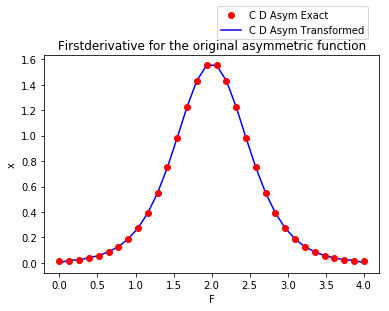

In [24]:
fig_cosinetransforms = plt.figure()
fig,ax = plt.subplots()
pct1, = plt.plot(x_grid_cosine,fasym_tanh_d, 'b-')
pct2, = plt.plot(x_grid_cosine,fasymtanh_d_exact, 'ro')
plt.legend([pct2, pct1], ["C D Asym Exact", "C D Asym Transformed"],bbox_to_anchor=(.5, 1.05))
#plt.ylim(0,1.)
#plt.xlim(-1.1,1.1)
plt.title('Firstderivative for the original asymmetric function')
plt.xlabel('F')
plt.ylabel('x')
plt.show()
